Install those packages

In [ ]:
%pip install duckdb 
%pip install llama-index-vector-stores-duckdb
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-embeddings-clip

%pip install llama_index ftfy regex tqdm
%pip install -U openai-whisper
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install moviepy
%pip install pytubefix
%pip install pydub
%pip install SpeechRecognition
%pip install ffmpeg-python
%pip install soundfile

Set configuration for input below

In [1]:
from moviepy.editor import VideoFileClip
from pathlib import Path
import speech_recognition as sr
from pytubefix import YouTube
from pytubefix.cli import on_progress
from pprint import pprint

In [2]:
import os

OPENAI_API_KEY = "sk-sFFtqJKYjbGMpxHZMF7UvMgiqvZJHvi2_ST-hxn7VIT3BlbkFJ87nylkw2qz5YN3JgLlPIJnDwQS80Sbq88IZp15HkEA"
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [3]:

video_url = "https://www.youtube.com/watch?v=ZOfL7arNaIQ"
output_video_path = "./video_data/"
output_folder = "./mixed_data/"
output_audio_path = "./mixed_data/output_audio.wav"

filepath = output_video_path + "input_vid.mp4"
Path(output_folder).mkdir(parents=True, exist_ok=True)

Setup image display, only display 7 images

In [4]:

from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 7:
                break

Function to download and process videos into appropriate format for generating/storing embeddings

In [5]:
def download_video(url, output_path):
    """
    Download a video from a given url and save it to the output path.

    Parameters:
    url (str): The url of the video to download.
    output_path (str): The path to save the video to.

    Returns:
    dict: A dictionary containing the metadata of the video.
    """
    yt = YouTube(url)
    metadata = {"Author": yt.author, "Title": yt.title, "Views": yt.views}
    yt.streams.get_highest_resolution().download(
        output_path=output_path, filename="input_vid.mp4"
    )
    return metadata


def video_to_images(video_path, output_folder):
    """
    Convert a video to a sequence of images and save them to the output folder.

    Parameters:
    video_path (str): The path to the video file.
    output_folder (str): The path to the folder to save the images to.

    """
    clip = VideoFileClip(video_path)
    clip.write_images_sequence(
        os.path.join(output_folder, "frame%04d.png"), fps=0.2
    )


def video_to_audio(video_path, output_audio_path):
    """
    Convert a video to audio and save it to the output path.

    Parameters:
    video_path (str): The path to the video file.
    output_audio_path (str): The path to save the audio to.

    """
    clip = VideoFileClip(video_path)
    audio = clip.audio
    audio.write_audiofile(output_audio_path)


def audio_to_text(audio_path):
    """
    Convert audio to text using the SpeechRecognition library.

    Parameters:
    audio_path (str): The path to the audio file.

    Returns:
    test (str): The text recognized from the audio.

    """
    recognizer = sr.Recognizer()
    audio = sr.AudioFile(audio_path)

    with audio as source:
        # Record the audio data
        audio_data = recognizer.record(source)

        try:
            # Recognize the speech
            text = recognizer.recognize_whisper(audio_data)
        except sr.UnknownValueError:
            print("Speech recognition could not understand the audio.")
        except sr.RequestError as e:
            print(f"Could not request results from service; {e}")

    return text

In [ ]:
Download the video convert to image and audio save to file

In [6]:
try:
    metadata_vid = download_video(video_url, output_video_path)
    video_to_images(filepath, output_folder)
    video_to_audio(filepath, output_audio_path)
    text_data = audio_to_text(output_audio_path)

    with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
    print("Text data saved to file")
    file.close()
    os.remove(output_audio_path)
    print("Audio file removed")

except Exception as e:
    raise e

Moviepy - Writing frames ./mixed_data/frame%04d.png.


Moviepy - Done writing frames ./mixed_data/frame%04d.png.
MoviePy - Writing audio in ./mixed_data/output_audio.wav


MoviePy - Done.
Text data saved to file
Audio file removed


Create the multi-modal index

In [7]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader, StorageContext

from llama_index.vector_stores.duckdb import DuckDBVectorStore



text_store = DuckDBVectorStore(database_name = "ratio",table_name = "text_collection",persist_dir="./", embed_dim=1536)
image_store = DuckDBVectorStore(database_name = "ratio",table_name = "image_collection",persist_dir="./", embed_dim=512)


storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader(output_folder).load_data()

index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

Use index as retriever to fetch top k (5 in this example) results from the multimodal vector index

In [8]:
retriever_engine = index.as_retriever(
    similarity_top_k=5, image_similarity_top_k=5
)

Set the RAG prompt template

In [9]:
import json

metadata_str = json.dumps(metadata_vid)

qa_tmpl_str = (
    "Given the provided information, including relevant images and retrieved context from the video, \
 accurately and precisely answer the query without any additional prior knowledge.\n"
    "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

Retrieve most similar text/image embeddings baseed on user query from the DB

In [10]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

Add query now, fetch relevant details including images and augment the prompt template

**Node ID:** 4fc6a3dd-b4af-4998-b601-16b2c9f2db85<br>**Similarity:** 0.8396070185163566<br>**Text:** How good are your ratio skills for PSLE? Let's test them out with this math ratio question. Ben, Jimmy and Sam each had some marbles. They each used the same number of marbles in a game. Ben used o...<br>

**Node ID:** 98099759-e534-43c5-be75-025d9d9bb7da<br>**Similarity:** 0.8345932072105723<br>**Text:** So instead of doing our working on our model, let's just make use of our fractions. Do you see that the numbers on top corresponds to the number of units that we want to make equal here? So the sho...<br>

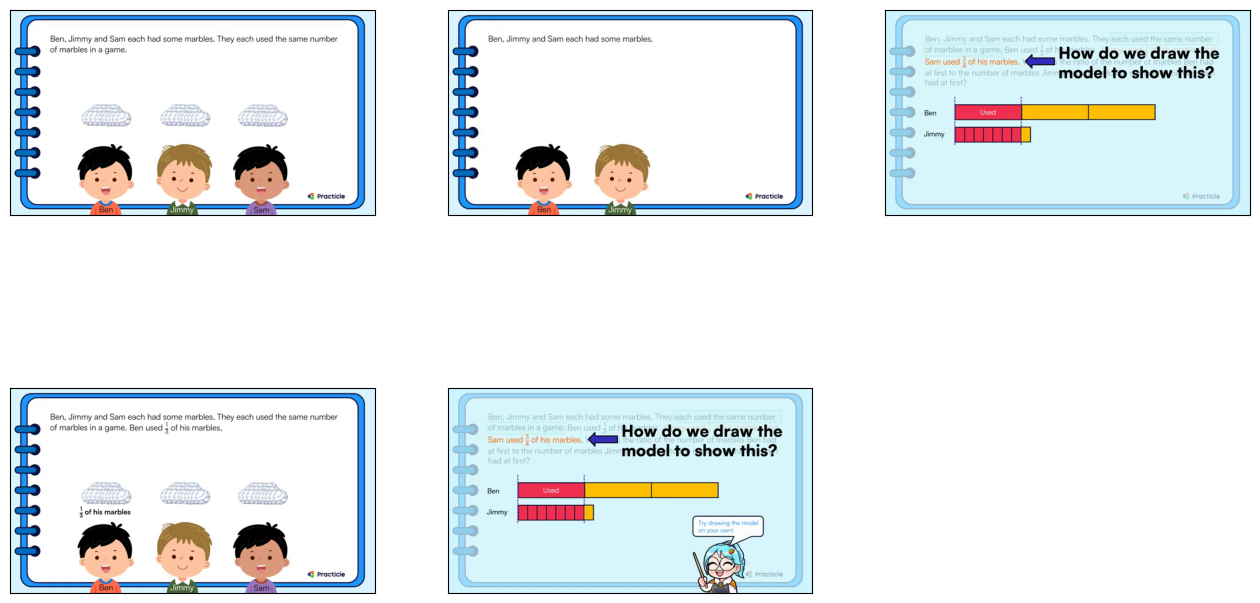

In [12]:
query_str = "Using examples from video, show steps to solve the ration problem."
##This portion can be ignore
img, txt = retrieve(retriever_engine=retriever_engine, query_str=query_str)
image_documents = SimpleDirectoryReader(
    input_dir=output_folder, input_files=img
).load_data()
context_str = "".join(txt)
plot_images(img)

Generate final response using GPT4V

In [13]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key=OPENAI_API_KEY, max_new_tokens=1500
)


response_1 = openai_mm_llm.complete(
    prompt=qa_tmpl_str.format(
        context_str=context_str, query_str=query_str, metadata_str=metadata_str
    ),
    image_documents=image_documents,
)

pprint(response_1.text)

('To solve the ratio problem using the examples from the video, follow these '
 'steps:\n'
 '\n'
 '1. **Understand the Problem:**\n'
 '   - Ben used one-third of his marbles.\n'
 '   - Jimmy used seven-eighths of his marbles.\n'
 '   - Sam used three-quarters of his marbles.\n'
 '   - All three boys used the same number of marbles.\n'
 '\n'
 '2. **Draw the Models:**\n'
 "   - **Ben's Marbles:**\n"
 '     - Ben used one-third of his marbles. \n'
 '     - Draw a bar divided into 3 equal parts. Ben used 1 part out of 3.\n'
 '     - This means Ben has 3 units in total.\n'
 '\n'
 "   - **Jimmy's Marbles:**\n"
 '     - Jimmy used seven-eighths of his marbles.\n'
 '     - Draw a bar divided into 8 equal parts. Jimmy used 7 parts out of 8.\n'
 '     - This means Jimmy has 8 units in total.\n'
 '\n'
 "   - **Sam's Marbles:**\n"
 '     - Sam used three-quarters of his marbles.\n'
 '     - Draw a bar divided into 4 equal parts. Sam used 3 parts out of 4.\n'
 '     - This means Sam has 4 units in 

Let try a problem form the last part of the video

In [14]:
query_str = "Using examples from video, Can you solve this other ratio question Jack, Ali and Bala had some gold coins. Each of them used the same number of gold coins to upgrade their spell factory.Jack used 2/3 of his gold coins. Ali used 1/2 of his gold coins and Bala used 4/5 of his gold coins. Find the ratio of the number of gold coins Jack had at first to the number of gold coins Ali had at first to the number of gold coins Bala had at first?"

Steps by steps to solve the problem & result

In [15]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key=OPENAI_API_KEY, max_new_tokens=1500
)


response_1 = openai_mm_llm.complete(
    prompt=qa_tmpl_str.format(
        context_str=context_str, query_str=query_str, metadata_str=metadata_str
    ),
    image_documents=image_documents,
)

pprint(response_1.text)

('To solve the ratio question for Jack, Ali, and Bala using the method '
 'described in the video, we need to follow these steps:\n'
 '\n'
 '1. **Identify the fractions of gold coins used by each person:**\n'
 '   - Jack used \\( \\frac{2}{3} \\) of his gold coins.\n'
 '   - Ali used \\( \\frac{1}{2} \\) of his gold coins.\n'
 '   - Bala used \\( \\frac{4}{5} \\) of his gold coins.\n'
 '\n'
 '2. **Set up the fractions to find a common numerator:**\n'
 '   - Jack: \\( \\frac{2}{3} \\)\n'
 '   - Ali: \\( \\frac{1}{2} \\)\n'
 '   - Bala: \\( \\frac{4}{5} \\)\n'
 '\n'
 '3. **Find a common multiple for the numerators (2, 1, and 4).**\n'
 '   - The least common multiple (LCM) of 2, 1, and 4 is 4.\n'
 '\n'
 '4. **Convert each fraction to have the same numerator (4):**\n'
 '   - Jack: \\( \\frac{2}{3} = \\frac{4}{6} \\)\n'
 '   - Ali: \\( \\frac{1}{2} = \\frac{4}{8} \\)\n'
 '   - Bala: \\( \\frac{4}{5} = \\frac{4}{5} \\)\n'
 '\n'
 '5. **Determine the denominators for each fraction:**\n'
 '   -